In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from feature_selection import FeatureSelection 

In [23]:
class Config:
    test_size = 0.2
    seed = 20
    nan_threshold = 50#cols with more than 50% nan entries will be deleted  
    corr_tresh = 0.8

In [41]:
df = pd.read_csv('TECH_TASK_TRAIN.csv')
test = pd.read_csv('TECH_TASK_TEST.csv', index_col=[0])


df.shape, test.shape

((20138, 416), (10000, 415))

In [25]:
test.head(3)

,ID,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,...,FEATURE_405,FEATURE_406,FEATURE_407,FEATURE_408,FEATURE_409,FEATURE_410,FEATURE_411,FEATURE_412,FEATURE_413,FEATURE_414
0,1-35972079318,0.022489,0.294317,0.000000,4.997912,0.000000,11.187358,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,-1.0,NaN,NaN
1,1-34716644135,2.829745,5.947975,0.000097,26.258384,0.004262,4.896823,0.0,0.0,0.0,...,NaN,NaN,755.636204,755.636204,-1.0,-1.0,NaN,-1.0,NaN,NaN
2,1-35386843231,0.142518,0.175110,0.000019,0.706647,0.063928,2.647362,0.0,0.0,0.0,...,NaN,NaN,0.000000,0.000000,-1.0,-1.0,NaN,-1.0,NaN,NaN


# Huge class imbalance

In [26]:
df['TARGET'].value_counts()

0    20000
1      138
Name: TARGET, dtype: int64

In [27]:
df_target_id = df[['TARGET', 'ID']]
df = df[[i for i in df.columns if i != 'TARGET' and i != 'ID']]

# Dtypes

In [28]:
df.dtypes.value_counts()

float64    373
int64       30
object      11
dtype: int64

# Nan Values

In [32]:
def get_nan_percent(df):
    columns = list(df.columns)
    num_rows = df.shape[0]
    nan_list = []
    for col in columns:
        nan_percent = df[col].isna().sum()
        nan_list.append((nan_percent/num_rows)*100)
    df_nan_count = pd.DataFrame(list(zip(columns, nan_list)), columns =['column_name', 'nan_percent'])
    return df_nan_count

df_nan_count = get_nan_percent(df)
df_nan_count.head()

,column_name,nan_percent
0,FEATURE_1,0.153938
1,FEATURE_2,0.153938
2,FEATURE_3,0.153938
3,FEATURE_4,0.153938
4,FEATURE_5,0.153938


In [33]:
thresholds = [i for i in range(30, 110, 10)]
nan_percentage = []
for threshold in thresholds:
    nans = df_nan_count.loc[df_nan_count.nan_percent >= threshold].shape[0]
    nan_percentage.append(nans)

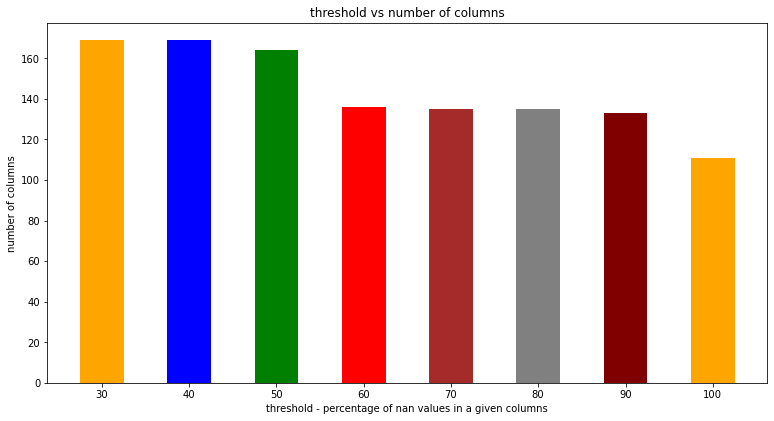

In [34]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(thresholds,nan_percentage, color =['orange', 'blue', 'green', 'red', 'brown', 'gray', 'maroon'], width = 5)

plt.xlabel("threshold - percentage of nan values in a given columns")
plt.ylabel("number of columns")
plt.title("threshold vs number of columns")


plt.show()

lots of columns, where more than 50% of entries are missing, 111 columns has no entries at all, I will delete the columns with 30 or more percent of data are nans

In [35]:
def get_blacklist_nanpercent(df_nan_count, threshold=50):
    blacklist = df_nan_count.loc[df_nan_count.nan_percent >= threshold].column_name.tolist()
    print(f'length blacklist {len(blacklist)}')
    return blacklist

In [36]:
blacklist = get_blacklist_nanpercent(df_nan_count, threshold=Config.nan_threshold)

length blacklist 164


In [37]:
def remove_cols(df, blacklist):
    df = df[[i for i in df.columns if i not in blacklist]]
    return df

In [38]:
df = remove_cols(df, blacklist)

In [39]:
df.dtypes.value_counts()

float64    213
int64       30
object       7
dtype: int64

# Only one unique value in the column
remove constant columns since it does not give any information for the model

In [40]:
def get_constant_cols(df):
    one_unique = []
    for col in df.columns:
        unique_values = df[col].value_counts().shape[0]
        if unique_values == 1:
            one_unique.append(col)
    return one_unique

In [41]:
one_unique = get_constant_cols(df)
print(f'number of columns with only 1 unique value {len(one_unique)}')

number of columns with only 1 unique value 20


### Example of constant column

In [42]:
df[one_unique[0]].value_counts()

100000    20138
Name: FEATURE_25, dtype: int64

In [43]:
blacklist.extend(one_unique)

In [44]:
df = remove_cols(df, blacklist)

In [45]:
df.dtypes.value_counts()

float64    213
int64       12
object       5
dtype: int64

# Quasi Constant values
remove quasi constant features - features where majority of entries are one number/class

In [46]:
def get_numerical_dataframe(df):
    df_objects = df.select_dtypes(include='object')
    nonnumerical_features = df_objects.columns.tolist()

    numerical_df = df[[i for i in df.columns if i not in nonnumerical_features]]
    return numerical_df


df_numerical = get_numerical_dataframe(df)


quasiModel=VarianceThreshold(threshold=0.01) #It will search for the features having 99% of same value in all samples.

quasiModel.fit(df_numerical)

VarianceThreshold(threshold=0.01)

In [47]:
quasiArr=quasiModel.get_support()
quasiCols=[col for col in df_numerical.columns if col not in df_numerical.columns[quasiArr]]

In [48]:
quasiCols

['FEATURE_54',
 'FEATURE_57',
 'FEATURE_132',
 'FEATURE_191',
 'FEATURE_230',
 'FEATURE_254',
 'FEATURE_361']

In [49]:
blacklist.extend(quasiCols)

In [50]:
df = remove_cols(df, blacklist)

In [51]:
df.dtypes.value_counts()

float64    212
int64        6
object       5
dtype: int64

# Duplicated columns

remove duplicated columns - since it does not give any info for the model

In [52]:
def get_duplicated_cols(df):
    df_T = df.T
    print(f'number of duplicated cols = {df_T.duplicated().sum()}')
    new_df = df_T.drop_duplicates(keep='first').T
    duplicated_cols = [dup_col for dup_col in df.columns if dup_col not in new_df.columns]
    return duplicated_cols

In [53]:
duplicated_cols = get_duplicated_cols(df)
blacklist.extend(duplicated_cols)

number of duplicated cols = 1


In [54]:
df = remove_cols(df, blacklist)

In [55]:
df.shape

(20138, 222)

# Correlated Features
remove highly correlated features

In [56]:
numerical_df = get_numerical_dataframe(df)
correlation_matrix = numerical_df.corr()

In [57]:
correlation_matrix.head()

,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_13,...,FEATURE_353,FEATURE_376,FEATURE_377,FEATURE_385,FEATURE_386,FEATURE_387,FEATURE_407,FEATURE_409,FEATURE_410,FEATURE_412
FEATURE_1,1.000000,0.819727,0.092555,0.004071,0.001243,0.006318,0.000321,0.000908,0.000443,0.002472,...,0.001903,0.141034,0.004608,0.010035,0.010051,0.005980,-0.002548,0.000178,0.000215,0.000686
FEATURE_2,0.819727,1.000000,0.631573,0.002187,0.001296,0.007282,0.000382,0.001042,0.000521,0.002867,...,0.002216,0.000372,0.001401,0.010229,0.009163,0.005367,-0.012693,0.000204,0.000251,0.000722
FEATURE_3,0.092555,0.631573,1.000000,-0.001437,0.001076,0.005649,-0.000025,0.000548,0.000608,0.002654,...,0.001829,0.013295,-0.003227,0.006343,0.005579,0.004244,-0.012326,0.000234,0.000290,0.000634
FEATURE_4,0.004071,0.002187,-0.001437,1.000000,0.111275,0.212627,0.085541,0.143838,-0.003630,0.044353,...,0.045936,0.005358,0.128127,0.149507,0.146220,0.148914,0.028813,0.021582,0.009393,0.067500
FEATURE_5,0.001243,0.001296,0.001076,0.111275,1.000000,0.068014,0.003278,0.012134,-0.000364,-0.005568,...,0.007522,0.001561,0.025132,0.103165,0.121512,0.116190,-0.011410,0.000244,-0.001045,0.003424


In [58]:

def get_highly_corr_feat(df, threshold=0.8):
    
    numerical_df = get_numerical_dataframe(df)
    
    corr_features = []
    num_cols = numerical_df.shape[1]
    
    corr_features = set()
    for i in range(0, num_cols):
        for j in range(0, i):
            if abs(correlation_matrix.iloc[i, j]) >= threshold:
                corr_features.add(correlation_matrix.columns[i])
    return corr_features
    

In [59]:
corr_features = get_highly_corr_feat(df, threshold=Config.corr_tresh)

In [60]:
len(corr_features)

105

In [61]:
blacklist.extend(list(corr_features))

In [62]:
df = remove_cols(df, blacklist)

In [63]:
df.dtypes.value_counts()

float64    107
object       5
int64        5
dtype: int64

# Dtypes object, fillna


In [64]:
df_objects = df.select_dtypes(include='object')
object_cols = [i for i in df_objects.columns if i != 'FEATURE_121']
df_objects.head()

,FEATURE_27,FEATURE_33,FEATURE_106,FEATURE_121,FEATURE_300
0,Category_1,Category_1,NaN,2022-10-28 15:55:51,Category_2
1,Category_2,Category_1,NaN,1969-12-12 06:43:12,Category_2
2,Category_1,Category_1,Y,2022-10-20 22:02:43,Category_1
3,Category_1,Category_1,Y,1969-12-12 06:43:12,Category_1
4,Category_1,Category_1,Y,1969-12-12 06:43:12,Category_2


In [65]:
for col in object_cols:
    print(df[col].value_counts())
    print()

Category_1    19604
Category_2      451
Category_3       83
Name: FEATURE_27, dtype: int64

Category_1    20108
Category_2       25
Name: FEATURE_33, dtype: int64

Y    14295
N       38
Name: FEATURE_106, dtype: int64

Category_2    12244
Category_1     5440
Name: FEATURE_300, dtype: int64



In [66]:
blacklist.append('FEATURE_33')#feature_33 is hugely imbalanced - so better to remove it, since it almost like constant column

In [67]:
df = remove_cols(df, blacklist)

## Fillna

In [68]:
df['FEATURE_106'].fillna('Y', inplace=True)#most of entries are Y, so lets just fill Nans with Y
df['FEATURE_300'].fillna('Category_3', inplace=True)#no such imbalance, so let's fill nans with 3 extra class

# Train

So after feature selection and preprocessing, we can do training

In [46]:
import xgboost as xgb
from metric import pfbeta
import pandas as pd
train = pd.read_csv('./utils/train_preprocessed.csv')
val = pd.read_csv('./utils/val_preprocessed.csv')
test = pd.read_csv('./utils/test_preprocessed.csv')

In [47]:
train.shape

(16110, 118)

In [28]:
y_train = train['TARGET']
X_train = train.drop(['ID', 'TARGET', 'FEATURE_121'], axis=1)

y_val = val['TARGET']
X_val = val.drop(['ID', 'TARGET', 'FEATURE_121'], axis=1)

X_test = test.drop(['ID', 'FEATURE_121'], axis=1)


In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}


xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="average_precision")

_ = grid_cv.fit(X_train, y_train)

In [30]:
grid_cv.best_score_

0.7095490192008681

In [31]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 0,
 'scale_pos_weight': 5,
 'subsample': 0.8}

In [32]:
xgb_cl = xgb.XGBClassifier(**grid_cv.best_params_)

# Fit
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=5, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
val_preds = xgb_cl.predict(X_val)

In [34]:
pfbeta(labels=y_val.to_numpy(), predictions=val_preds)

0.75

In [35]:
train_preds = xgb_cl.predict(X_train)

In [36]:
pfbeta(labels=y_train.to_numpy(), predictions=train_preds)

0.9818181818181818

In [40]:
preds_test = xgb_cl.predict(X_test)

In [41]:
preds_test

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
test['TARGET'] = preds_test

In [45]:
#test.to_csv('test_predicted.csv', index=False)